### Data Dictionary

    Population - the population estimate of the state in 1975
    Income - per capita income in 1974
    Illiteracy - illiteracy rates in 1970, as a percent of the population
    Life.Exp - the life expectancy in years of residents of the state in 1970
    Murder - the murder and non-negligent manslaughter rate per 100,000 population in 1976 
    HS.Grad - percent of high-school graduates in 1970
    Frost - the mean number of days with minimum temperature below freezing from 1931–1960 in the capital or a large city of the state
    Area - the land area (in square miles) of the state
    state.abb - a 2-letter abreviation for each state
    state.area - the area of each state, in square miles
    x - the longitude of the center of the state
    y - the latitude of the center of the state
    state.division - the division each state belongs to (New England, Middle Atlantic, South Atlantic, East South Central, West South Central, East North Central, West North Central, Mountain, or Pacific)
    state.name - the full names of each state
    state.region - the region each state belong to (Northeast, South, North Central, or West)


We would like to build a model to predict life expectancy by state using the state statistics we have in our dataset.

Build the model with all potential variables included (Population, Income, Illiteracy, Murder, HS.Grad, Frost, and Area). 

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("statedata.csv")

In [3]:
df.head()

,Population,Income,Illiteracy,Lifeexp,Murder,HSgrad,Frost,Area,stateabb,statearea,x,y,statedivision,statename,stateregion
0,3615,3624,2.1,69.05,15.1,41.3,20,50708,AL,51609,-86.7509,32.5901,East South Central,Alabama,South
1,365,6315,1.5,69.31,11.3,66.7,152,566432,AK,589757,-127.2500,49.2500,Pacific,Alaska,West
2,2212,4530,1.8,70.55,7.8,58.1,15,113417,AZ,113909,-111.6250,34.2192,Mountain,Arizona,West
3,2110,3378,1.9,70.66,10.1,39.9,65,51945,AR,53104,-92.2992,34.7336,West South Central,Arkansas,South
4,21198,5114,1.1,71.71,10.3,62.6,20,156361,CA,158693,-119.7730,36.5341,Pacific,California,West


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Population     50 non-null     int64  
 1   Income         50 non-null     int64  
 2   Illiteracy     50 non-null     float64
 3   Lifeexp        50 non-null     float64
 4   Murder         50 non-null     float64
 5   HSgrad         50 non-null     float64
 6   Frost          50 non-null     int64  
 7   Area           50 non-null     int64  
 8   stateabb       50 non-null     object 
 9   statearea      50 non-null     int64  
 10  x              50 non-null     float64
 11  y              50 non-null     float64
 12  statedivision  50 non-null     object 
 13  statename      50 non-null     object 
 14  stateregion    50 non-null     object 
dtypes: float64(6), int64(5), object(4)
memory usage: 6.0+ KB


In [5]:
df.describe()

,Population,Income,Illiteracy,Lifeexp,Murder,HSgrad,Frost,Area,statearea,x,y
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,4246.420000,4435.800000,1.170000,70.878600,7.37800,53.108000,104.460000,70735.880000,72367.980000,-92.464138,39.410740
std,4464.491433,614.469939,0.609533,1.342394,3.69154,8.076998,51.980848,85327.299622,88278.006201,16.180787,4.976349
min,365.000000,3098.000000,0.500000,67.960000,1.40000,37.800000,0.000000,1049.000000,1214.000000,-127.250000,27.874400
25%,1079.500000,3992.750000,0.625000,70.117500,4.35000,48.050000,66.250000,36985.250000,37317.000000,-104.159500,35.548150
50%,2838.500000,4519.000000,0.950000,70.675000,6.85000,53.250000,114.500000,54277.000000,56222.000000,-89.900300,39.620750
75%,4968.500000,4813.500000,1.575000,71.892500,10.67500,59.150000,139.750000,81162.500000,83233.750000,-78.977850,43.136100
max,21198.000000,6315.000000,2.800000,73.600000,15.10000,67.300000,188.000000,566432.000000,589757.000000,-68.980100,49.250000


In [6]:
df.shape

(50, 15)

### Data Visualization

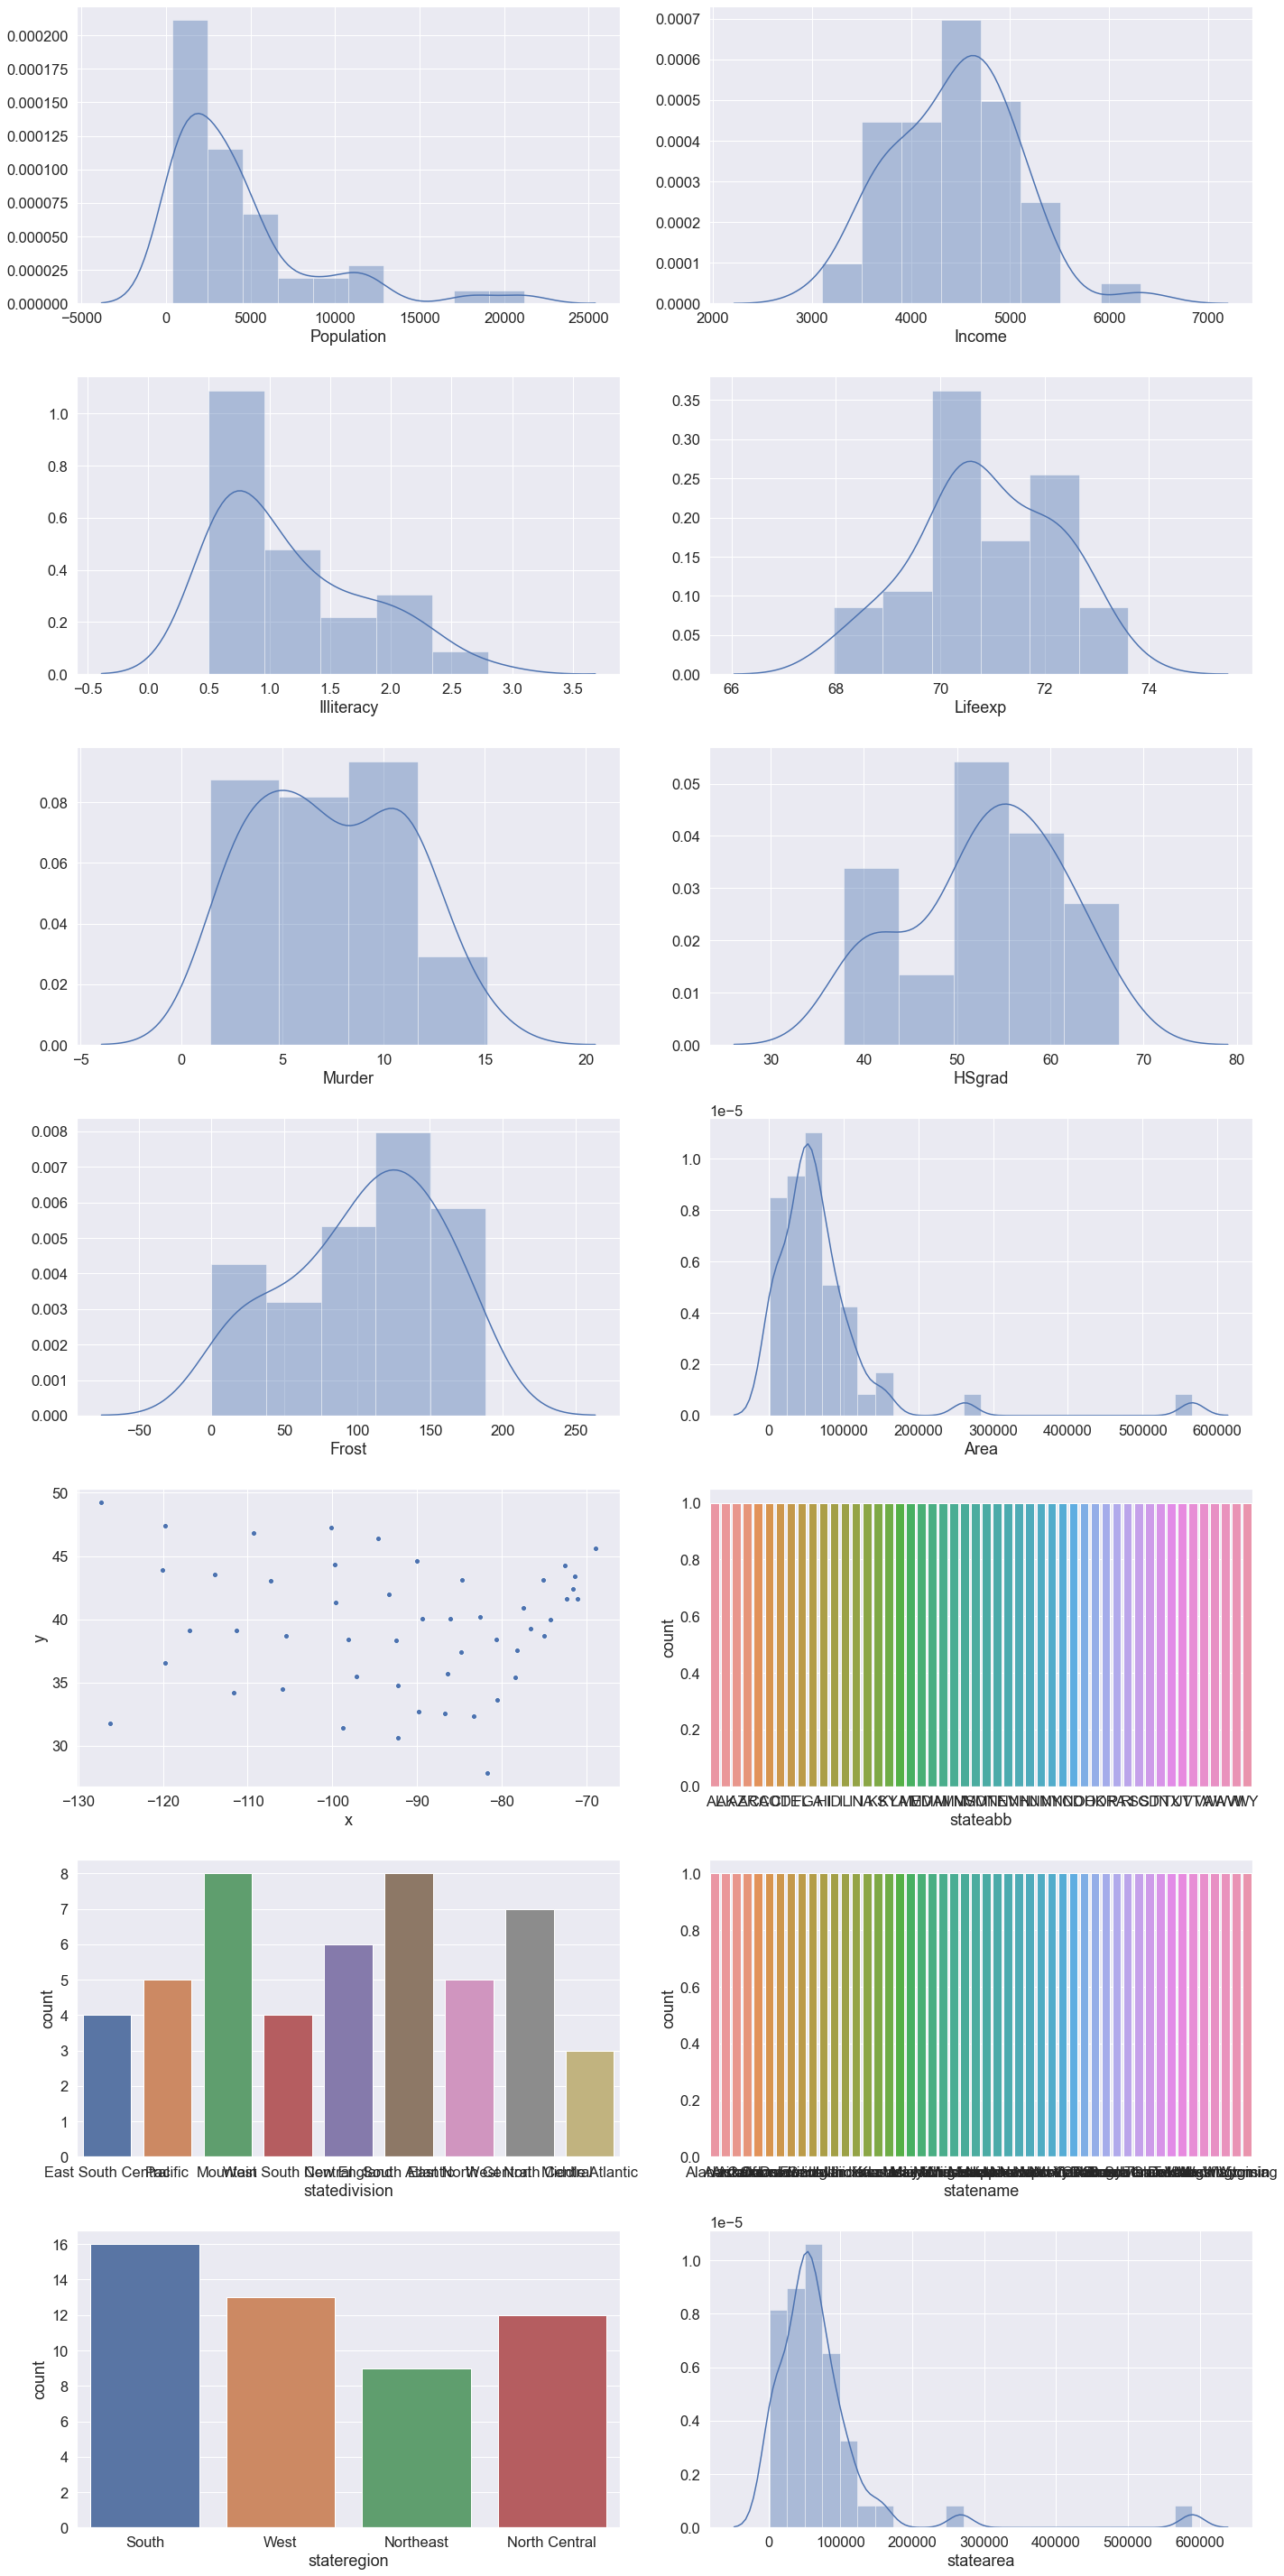

In [7]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.Population)
plt.subplot(7,2,2)
sns.distplot(df.Income)
plt.subplot(7,2,3)
sns.distplot(df.Illiteracy)
plt.subplot(7,2,4)
sns.distplot(df.Lifeexp)
plt.subplot(7,2,5)
sns.distplot(df.Murder)
plt.subplot(7,2,6)
sns.distplot(df.HSgrad)
plt.subplot(7,2,7)
sns.distplot(df.Frost)
plt.subplot(7,2,8)
sns.distplot(df.Area)
plt.subplot(7,2,9)
sns.scatterplot(x=df.x,y=df.y)
plt.subplot(7,2,10)
sns.countplot(df.stateabb)
plt.subplot(7,2,11)
sns.countplot(df.statedivision)
plt.subplot(7,2,12)
sns.countplot(df.statename)
plt.subplot(7,2,13)
sns.countplot(df.stateregion)
plt.subplot(7,2,14)
sns.distplot(df.statearea)

plt.tight_layout()
plt.show()

In [8]:
df.corr()

,Population,Income,Illiteracy,Lifeexp,Murder,HSgrad,Frost,Area,statearea,x,y
Population,1.000000,0.208228,0.107622,-0.068052,0.343643,-0.098490,-0.332152,0.022544,0.021567,0.154626,-0.171875
Income,0.208228,1.000000,-0.437075,0.340255,-0.230078,0.619932,0.226282,0.363315,0.365618,-0.237574,0.426546
Illiteracy,0.107622,-0.437075,1.000000,-0.588478,0.702975,-0.657189,-0.671947,0.077261,0.079862,0.095271,-0.732826
Lifeexp,-0.068052,0.340255,-0.588478,1.000000,-0.780846,0.582216,0.262068,-0.107332,-0.109632,-0.247983,0.406655
Murder,0.343643,-0.230078,0.702975,-0.780846,1.000000,-0.487971,-0.538883,0.228390,0.228794,-0.009053,-0.653628
HSgrad,-0.098490,0.619932,-0.657189,0.582216,-0.487971,1.000000,0.366780,0.333542,0.329880,-0.556176,0.508987
Frost,-0.332152,0.226282,-0.671947,0.262068,-0.538883,0.366780,1.000000,0.059229,0.058568,0.119782,0.712842
Area,0.022544,0.363315,0.077261,-0.107332,0.228390,0.333542,0.059229,1.000000,0.999825,-0.582648,0.184067
statearea,0.021567,0.365618,0.079862,-0.109632,0.228794,0.329880,0.058568,0.999825,1.000000,-0.575346,0.185670
x,0.154626,-0.237574,0.095271,-0.247983,-0.009053,-0.556176,0.119782,-0.582648,-0.575346,1.000000,-0.079006


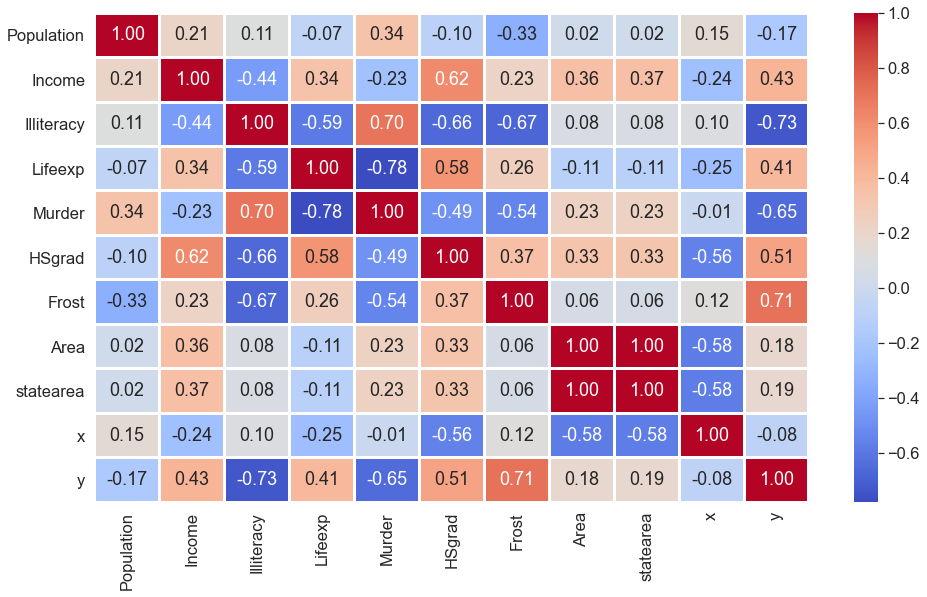

In [9]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

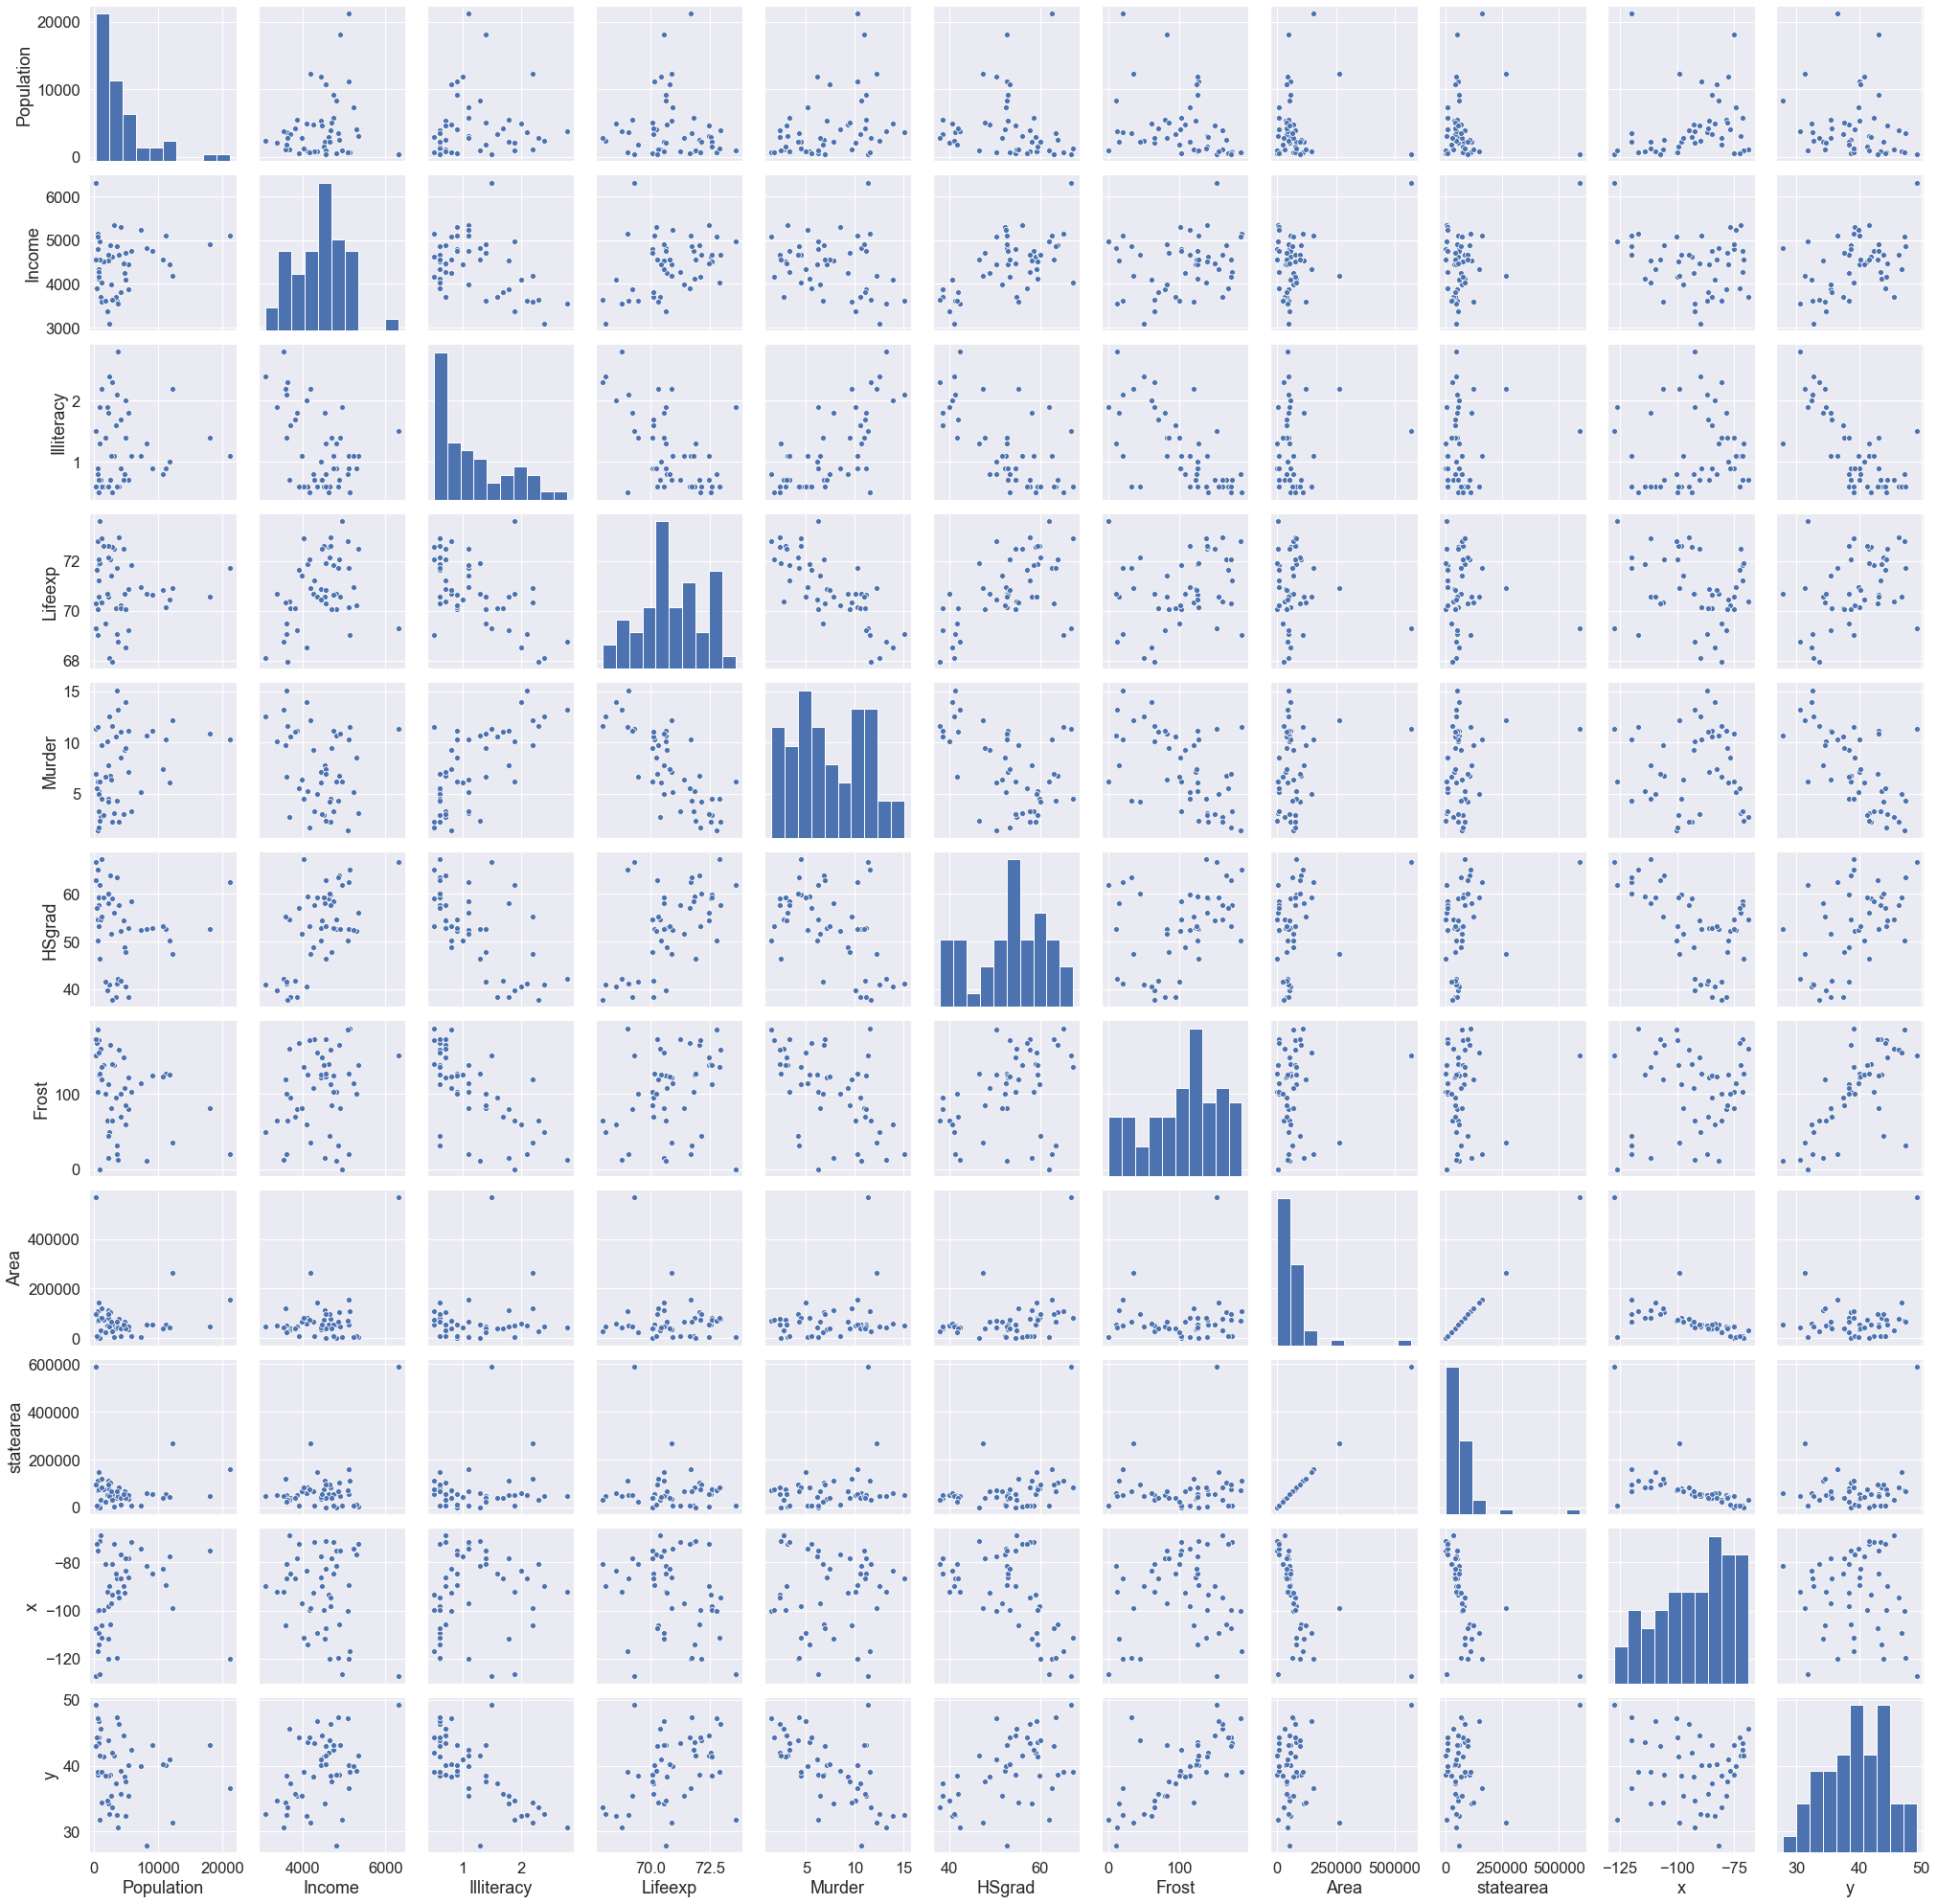

In [10]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [11]:
df.isnull().sum()

Population       0
Income           0
Illiteracy       0
Lifeexp          0
Murder           0
HSgrad           0
Frost            0
Area             0
stateabb         0
statearea        0
x                0
y                0
statedivision    0
statename        0
stateregion      0
dtype: int64

### Treat Duplicate Values

In [12]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [13]:
df.describe()

,Population,Income,Illiteracy,Lifeexp,Murder,HSgrad,Frost,Area,statearea,x,y
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,4246.420000,4435.800000,1.170000,70.878600,7.37800,53.108000,104.460000,70735.880000,72367.980000,-92.464138,39.410740
std,4464.491433,614.469939,0.609533,1.342394,3.69154,8.076998,51.980848,85327.299622,88278.006201,16.180787,4.976349
min,365.000000,3098.000000,0.500000,67.960000,1.40000,37.800000,0.000000,1049.000000,1214.000000,-127.250000,27.874400
25%,1079.500000,3992.750000,0.625000,70.117500,4.35000,48.050000,66.250000,36985.250000,37317.000000,-104.159500,35.548150
50%,2838.500000,4519.000000,0.950000,70.675000,6.85000,53.250000,114.500000,54277.000000,56222.000000,-89.900300,39.620750
75%,4968.500000,4813.500000,1.575000,71.892500,10.67500,59.150000,139.750000,81162.500000,83233.750000,-78.977850,43.136100
max,21198.000000,6315.000000,2.800000,73.600000,15.10000,67.300000,188.000000,566432.000000,589757.000000,-68.980100,49.250000


In [14]:
df.columns

Index(['Population', 'Income', 'Illiteracy', 'Lifeexp', 'Murder', 'HSgrad',
       'Frost', 'Area', 'stateabb', 'statearea', 'x', 'y', 'statedivision',
       'statename', 'stateregion'],
      dtype='object')

In [15]:
windsorizer = Winsorizer(distribution='skewed',tail='both',fold=1.5,
                         variables=['Population', 'Income', 'Illiteracy', 'Lifeexp', 'Murder', 'HSgrad',
                                   'Frost', 'Area'])

In [16]:
windsorizer.fit(df)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['Population', 'Income', 'Illiteracy', 'Lifeexp', 'Murder',
                      'HSgrad', 'Frost', 'Area'])

In [17]:
df2 = windsorizer.transform(df)

In [18]:
df2.head()

,Population,Income,Illiteracy,Lifeexp,Murder,HSgrad,Frost,Area,stateabb,statearea,x,y,statedivision,statename,stateregion
0,3615.0,3624.000,2.1,69.05,15.1,41.3,20.0,50708.000,AL,51609,-86.7509,32.5901,East South Central,Alabama,South
1,365.0,6044.625,1.5,69.31,11.3,66.7,152.0,147428.375,AK,589757,-127.2500,49.2500,Pacific,Alaska,West
2,2212.0,4530.000,1.8,70.55,7.8,58.1,15.0,113417.000,AZ,113909,-111.6250,34.2192,Mountain,Arizona,West
3,2110.0,3378.000,1.9,70.66,10.1,39.9,65.0,51945.000,AR,53104,-92.2992,34.7336,West South Central,Arkansas,South
4,10802.0,5114.000,1.1,71.71,10.3,62.6,20.0,147428.375,CA,158693,-119.7730,36.5341,Pacific,California,West


In [19]:
df2.describe()

,Population,Income,Illiteracy,Lifeexp,Murder,HSgrad,Frost,Area,statearea,x,y
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,3835.260000,4430.392500,1.170000,70.878600,7.37800,53.108000,104.460000,59883.042500,72367.980000,-92.464138,39.410740
std,3302.250759,598.579188,0.609533,1.342394,3.69154,8.076998,51.980848,40110.338217,88278.006201,16.180787,4.976349
min,365.000000,3098.000000,0.500000,67.960000,1.40000,37.800000,0.000000,1049.000000,1214.000000,-127.250000,27.874400
25%,1079.500000,3992.750000,0.625000,70.117500,4.35000,48.050000,66.250000,36985.250000,37317.000000,-104.159500,35.548150
50%,2838.500000,4519.000000,0.950000,70.675000,6.85000,53.250000,114.500000,54277.000000,56222.000000,-89.900300,39.620750
75%,4968.500000,4813.500000,1.575000,71.892500,10.67500,59.150000,139.750000,81162.500000,83233.750000,-78.977850,43.136100
max,10802.000000,6044.625000,2.800000,73.600000,15.10000,67.300000,188.000000,147428.375000,589757.000000,-68.980100,49.250000


In [20]:
windsorizer.left_tail_caps_

{'Population': -4754.0,
 'Income': 2761.625,
 'Illiteracy': -0.8000000000000003,
 'Lifeexp': 67.45499999999996,
 'Murder': -5.137499999999999,
 'HSgrad': 31.399999999999984,
 'Frost': -44.0,
 'Area': -29280.625}

In [21]:
windsorizer.right_tail_caps_

{'Population': 10802.0,
 'Income': 6044.625,
 'Illiteracy': 3.0000000000000004,
 'Lifeexp': 74.55500000000004,
 'Murder': 20.162499999999998,
 'HSgrad': 75.80000000000001,
 'Frost': 250.0,
 'Area': 147428.375}

### Treat Data Types

### Feature Scaling

In [22]:
df2 = df2[['Population', 'Income', 'Illiteracy', 'Murder', 'HSgrad', 'Frost', 'Area', 'Lifeexp']]

In [23]:
df2.head()

,Population,Income,Illiteracy,Murder,HSgrad,Frost,Area,Lifeexp
0,3615.0,3624.000,2.1,15.1,41.3,20.0,50708.000,69.05
1,365.0,6044.625,1.5,11.3,66.7,152.0,147428.375,69.31
2,2212.0,4530.000,1.8,7.8,58.1,15.0,113417.000,70.55
3,2110.0,3378.000,1.9,10.1,39.9,65.0,51945.000,70.66
4,10802.0,5114.000,1.1,10.3,62.6,20.0,147428.375,71.71


In [24]:
scaler = StandardScaler()

### Create and save processed dataset

### Model Training

In [25]:
X = df2.iloc[:,0:7]
y = df2.iloc[:,7]

In [26]:
X_scaled = scaler.fit_transform(X)

In [27]:
X_scaled

array([[-0.06737714, -1.36085492,  1.54124829,  2.11304729, -1.47677163,
        -1.64132535, -0.23106742],
       [-1.06154627,  2.72415263,  0.54689456,  1.07321568,  1.69988821,
         0.9238528 ,  2.20477175],
       [-0.4965523 ,  0.168096  ,  1.04407143,  0.11547604,  0.62432622,
        -1.73849119,  1.34821759],
       [-0.52775392, -1.77600054,  1.20979705,  0.7448478 , -1.65186312,
        -0.7668328 , -0.19991439],
       [ 2.13111319,  1.15364495, -0.11600794,  0.79957578,  1.18712028,
        -1.64132535,  2.20477175],
       [-0.3959118 ,  0.76550067, -0.77891043, -0.15816386,  1.34970524,
         1.19591715,  1.10516349],
       [-0.22491471,  1.54853956, -0.11600794, -1.17063148,  0.36168899,
         0.67122162, -1.38566885],
       [-0.99608405,  0.63893189, -0.44745918, -0.3223478 ,  0.1865975 ,
        -0.02837243, -1.45819976],
       [ 1.35872025,  0.64905739,  0.21544331,  0.90903174, -0.0635332 ,
        -1.81622386, -0.14589397],
       [ 0.33518489, -0.5727

In [28]:
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [29]:
X_scaled

,Population,Income,Illiteracy,Murder,HSgrad,Frost,Area
0,-0.067377,-1.360855,1.541248,2.113047,-1.476772,-1.641325,-0.231067
1,-1.061546,2.724153,0.546895,1.073216,1.699888,0.923853,2.204772
2,-0.496552,0.168096,1.044071,0.115476,0.624326,-1.738491,1.348218
3,-0.527754,-1.776001,1.209797,0.744848,-1.651863,-0.766833,-0.199914
4,2.131113,1.153645,-0.116008,0.799576,1.187120,-1.641325,2.204772
5,-0.395912,0.765501,-0.778910,-0.158164,1.349705,1.195917,1.105163
6,-0.224915,1.548540,-0.116008,-1.170631,0.361689,0.671222,-1.385669
7,-0.996084,0.638932,-0.447459,-0.322348,0.186597,-0.028372,-1.458200
8,1.358720,0.649057,0.215443,0.909032,-0.063533,-1.816224,-0.145894
9,0.335185,-0.572753,1.375523,1.784679,-1.564317,-0.863999,-0.045585


In [30]:
X_scaled.values, y.values

(array([[-0.06737714, -1.36085492,  1.54124829,  2.11304729, -1.47677163,
         -1.64132535, -0.23106742],
        [-1.06154627,  2.72415263,  0.54689456,  1.07321568,  1.69988821,
          0.9238528 ,  2.20477175],
        [-0.4965523 ,  0.168096  ,  1.04407143,  0.11547604,  0.62432622,
         -1.73849119,  1.34821759],
        [-0.52775392, -1.77600054,  1.20979705,  0.7448478 , -1.65186312,
         -0.7668328 , -0.19991439],
        [ 2.13111319,  1.15364495, -0.11600794,  0.79957578,  1.18712028,
         -1.64132535,  2.20477175],
        [-0.3959118 ,  0.76550067, -0.77891043, -0.15816386,  1.34970524,
          1.19591715,  1.10516349],
        [-0.22491471,  1.54853956, -0.11600794, -1.17063148,  0.36168899,
          0.67122162, -1.38566885],
        [-0.99608405,  0.63893189, -0.44745918, -0.3223478 ,  0.1865975 ,
         -0.02837243, -1.45819976],
        [ 1.35872025,  0.64905739,  0.21544331,  0.90903174, -0.0635332 ,
         -1.81622386, -0.14589397],
        [ 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 7), (10, 7), (40,), (10,))

In [33]:
xgb = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [34]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:64.0093
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:57.8247
[2]	validation_0-rmse:52.2438
[3]	validation_0-rmse:47.2077
[4]	validation_0-rmse:42.6633
[5]	validation_0-rmse:38.5626
[6]	validation_0-rmse:34.8624
[7]	validation_0-rmse:31.5236
[8]	validation_0-rmse:28.5111
[9]	validation_0-rmse:25.793
[10]	validation_0-rmse:23.3408
[11]	validation_0-rmse:21.1284
[12]	validation_0-rmse:19.1327
[13]	validation_0-rmse:17.3324
[14]	validation_0-rmse:15.7087
[15]	validation_0-rmse:14.2444
[16]	validation_0-rmse:12.9239
[17]	validation_0-rmse:11.7335
[18]	validation_0-rmse:10.6605
[19]	validation_0-rmse:9.6935
[20]	validation_0-rmse:8.82234
[21]	validation_0-rmse:8.03777
[22]	validation_0-rmse:7.33148
[23]	validation_0-rmse:6.6779
[24]	validation_0-rmse:6.08431
[25]	validation_0-rmse:5.55231
[26]	validation_0-rmse:5.06964
[27]	validation_0-rmse:4.67055
[28]	validation_0-rmse:4.29444
[29]	validation_0-rmse:3.96075
[30]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [35]:
y_pred = xgb.predict(X_test)

In [36]:
y_pred

array([72.19699 , 71.19361 , 70.780396, 69.65891 , 70.91373 , 70.21153 ,
       70.992805, 70.12793 , 72.45623 , 70.79429 ], dtype=float32)

### Model Evaluation

In [37]:
mse = mean_squared_error(y_test,y_pred)
mse

1.3167995748209256

In [38]:
rmse = np.sqrt(mse)
rmse

1.1475188777623335

In [39]:
r2score = r2_score(y_test,y_pred)
r2score

0.2053825124832297

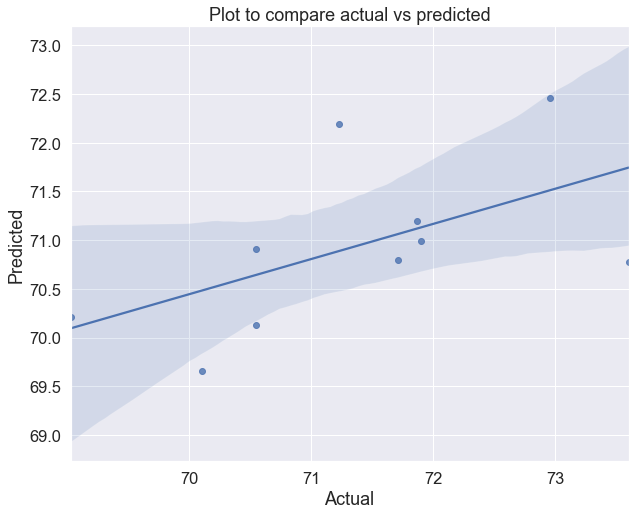

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

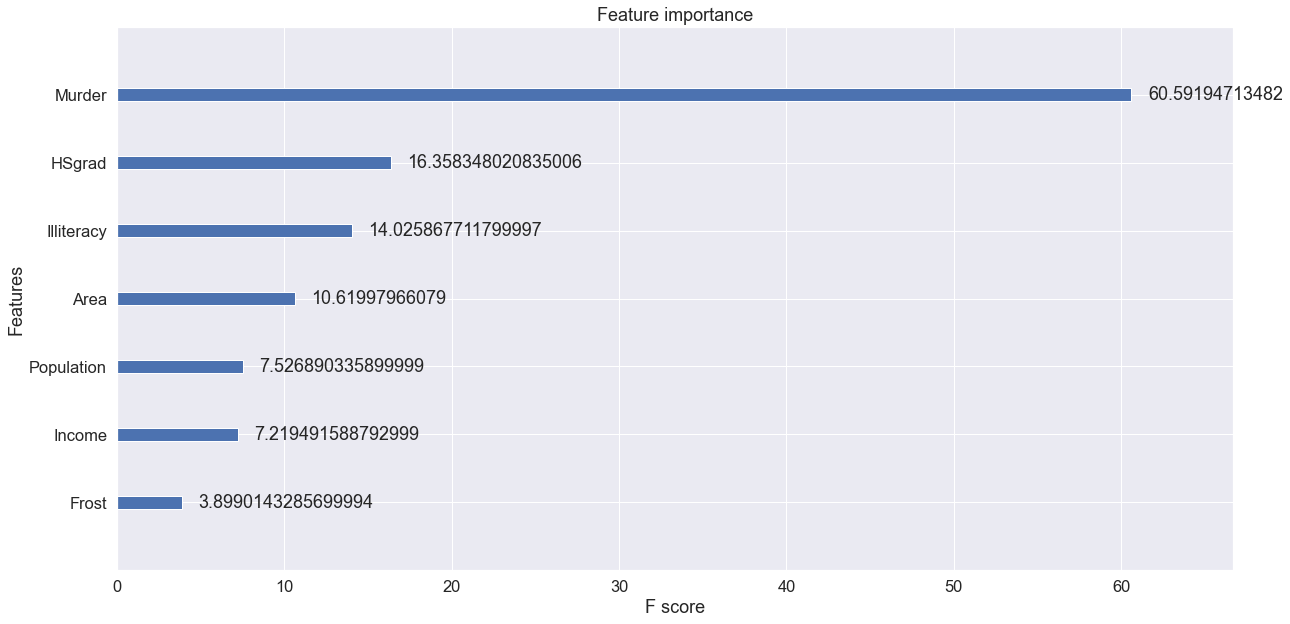

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax,importance_type='total_gain')
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [42]:
cv = cross_val_score(xgb,X_scaled,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [43]:
cv.mean()

0.3051087503652628

### Feature Selection

In [44]:
df3 = df2[['Illiteracy', 'Murder', 'HSgrad', 'Lifeexp']]

In [45]:
df3.head()

,Illiteracy,Murder,HSgrad,Lifeexp
0,2.1,15.1,41.3,69.05
1,1.5,11.3,66.7,69.31
2,1.8,7.8,58.1,70.55
3,1.9,10.1,39.9,70.66
4,1.1,10.3,62.6,71.71


In [46]:
X = df3.iloc[:,0:3]
y = df3.iloc[:,3]

In [47]:
X.values, y.values

(array([[ 2.1, 15.1, 41.3],
        [ 1.5, 11.3, 66.7],
        [ 1.8,  7.8, 58.1],
        [ 1.9, 10.1, 39.9],
        [ 1.1, 10.3, 62.6],
        [ 0.7,  6.8, 63.9],
        [ 1.1,  3.1, 56. ],
        [ 0.9,  6.2, 54.6],
        [ 1.3, 10.7, 52.6],
        [ 2. , 13.9, 40.6],
        [ 1.9,  6.2, 61.9],
        [ 0.6,  5.3, 59.5],
        [ 0.9, 10.3, 52.6],
        [ 0.7,  7.1, 52.9],
        [ 0.5,  2.3, 59. ],
        [ 0.6,  4.5, 59.9],
        [ 1.6, 10.6, 38.5],
        [ 2.8, 13.2, 42.2],
        [ 0.7,  2.7, 54.7],
        [ 0.9,  8.5, 52.3],
        [ 1.1,  3.3, 58.5],
        [ 0.9, 11.1, 52.8],
        [ 0.6,  2.3, 57.6],
        [ 2.4, 12.5, 41. ],
        [ 0.8,  9.3, 48.8],
        [ 0.6,  5. , 59.2],
        [ 0.6,  2.9, 59.3],
        [ 0.5, 11.5, 65.2],
        [ 0.7,  3.3, 57.6],
        [ 1.1,  5.2, 52.5],
        [ 2.2,  9.7, 55.2],
        [ 1.4, 10.9, 52.7],
        [ 1.8, 11.1, 38.5],
        [ 0.8,  1.4, 50.3],
        [ 0.8,  7.4, 53.2],
        [ 1.1,  6.4,

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
xgb2 = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [50]:
xgb2.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:64.0093
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:57.8247
[2]	validation_0-rmse:52.2438
[3]	validation_0-rmse:47.2077
[4]	validation_0-rmse:42.6633
[5]	validation_0-rmse:38.5626
[6]	validation_0-rmse:34.8624
[7]	validation_0-rmse:31.5236
[8]	validation_0-rmse:28.5111
[9]	validation_0-rmse:25.793
[10]	validation_0-rmse:23.3408
[11]	validation_0-rmse:21.1284
[12]	validation_0-rmse:19.1327
[13]	validation_0-rmse:17.3324
[14]	validation_0-rmse:15.7087
[15]	validation_0-rmse:14.2444
[16]	validation_0-rmse:12.9239
[17]	validation_0-rmse:11.7335
[18]	validation_0-rmse:10.6605
[19]	validation_0-rmse:9.6935
[20]	validation_0-rmse:8.82234
[21]	validation_0-rmse:8.03777
[22]	validation_0-rmse:7.33148
[23]	validation_0-rmse:6.6779
[24]	validation_0-rmse:6.08431
[25]	validation_0-rmse:5.55231
[26]	validation_0-rmse:5.06964
[27]	validation_0-rmse:4.67055
[28]	validation_0-rmse:4.29444
[29]	validation_0-rmse:3.96075
[30]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [51]:
y_pred2 = xgb2.predict(X_test)

In [52]:
y_pred2

array([72.14992 , 71.3806  , 70.812416, 69.5622  , 70.219315, 70.63692 ,
       71.71693 , 70.21502 , 72.27587 , 70.27951 ], dtype=float32)

In [53]:
r2score = r2_score(y_test,y_pred2)
r2score

0.12451669426837753

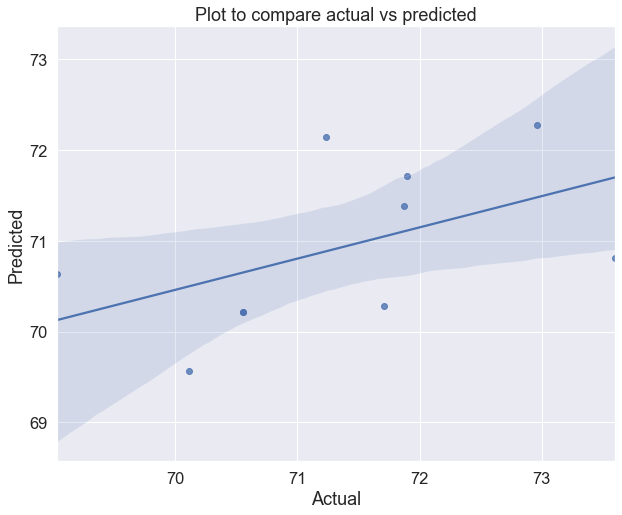

In [54]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred2, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

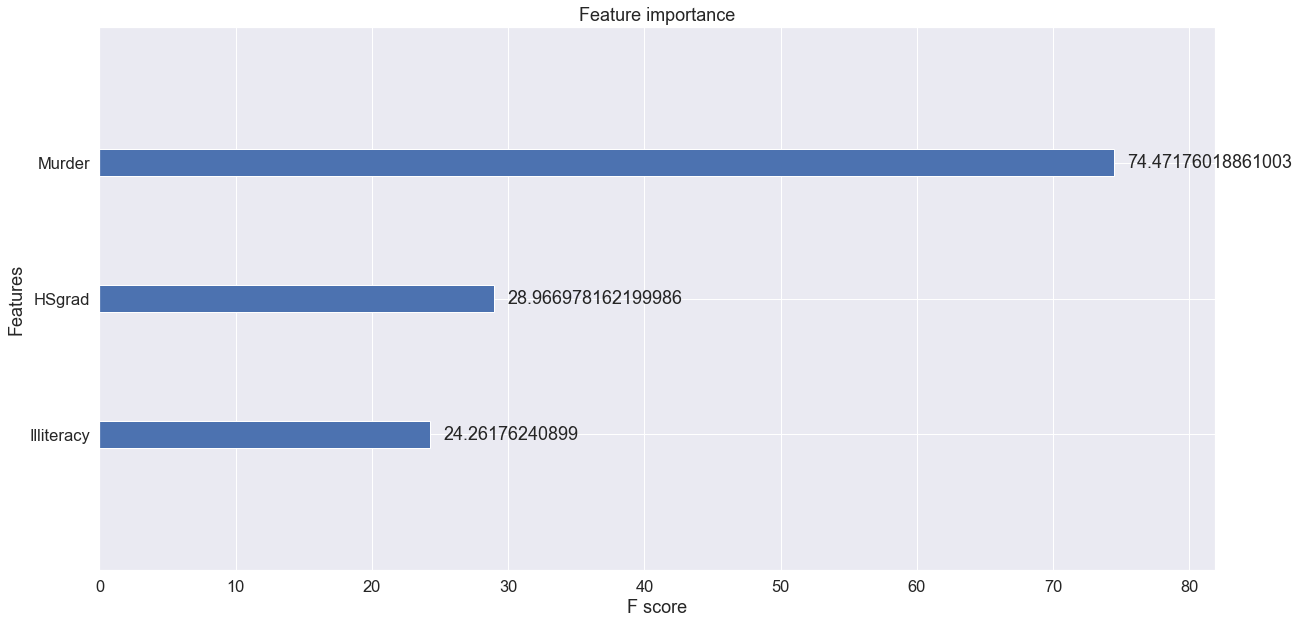

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb2,ax=ax,importance_type='total_gain')
plt.show()